In [1]:
# 首先要在本地和服务器运行测试脚本,需要root权限
# bash run_benchmark.sh
# 从服务器复制测试结果
# !mkdir -p rv_results
# !scp -r riscv-server:~/application_benchmark/redis/results rv_results
# !mv rv_results/results/* rv_results/ && rm -rf rv_results/results

In [2]:
# 可视化
import re
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import numpy as np
from functools import reduce
seaborn.set()

In [3]:
def read_files(path:str, pattern:str) -> list :
    results = []
    for root, dirs, files in os.walk(path):
            for file in files:
                if re.match(pattern, file) is not None:
                    results.append(file)
    return results

# list result files
local_dir = "./results"
local_results = read_files(local_dir, r'^(local).*(\.csv)$')
print(local_results)

rv_dir = "./rv_results"
rv_results = read_files(rv_dir, r'^(riscv_server).*(\.csv)$')
print(rv_results)


['local-redis-benchmark-client:100-query:20000.csv', 'local-redis-benchmark-client:250-query:50000.csv', 'local-redis-benchmark-client:300-query:60000.csv', 'local-redis-benchmark-client:50-query:10000.csv', 'local-redis-benchmark-client:500-query:100000.csv', 'local-redis-benchmark-client:450-query:90000.csv', 'local-redis-benchmark-client:200-query:40000.csv', 'local-redis-benchmark-client:150-query:30000.csv', 'local-redis-benchmark-client:350-query:70000.csv', 'local-redis-benchmark-client:400-query:80000.csv']
['riscv_server-redis-benchmark-client:400-query:80000.csv', 'riscv_server-redis-benchmark-client:250-query:50000.csv', 'riscv_server-redis-benchmark-client:500-query:100000.csv', 'riscv_server-redis-benchmark-client:300-query:60000.csv', 'riscv_server-redis-benchmark-client:450-query:90000.csv', 'riscv_server-redis-benchmark-client:200-query:40000.csv', 'riscv_server-redis-benchmark-client:350-query:70000.csv', 'riscv_server-redis-benchmark-client:50-query:10000.csv', 'riscv

In [4]:
# parse file name to get benchmark scale
def parse_scale(filename:str) -> str:
    filename = filename.removesuffix(".csv")
    tail = filename.split("-")[-2:]
    return (int(tail[0].split(":")[-1]), int(tail[1].split(":")[-1]))

# def find_base_scale(tuple_list:[]) -> ((int,int), int):


parse_scale('./results/local-redis-benchmark-client:400-query:80000.csv')

(400, 80000)

In [5]:


# map filename to ((client_num, requent_num), DataFrame)
def map_fun(dir:str, filename:str) -> ((int,int), pd.DataFrame):
    path = os.path.join(dir, filename)
    return (parse_scale(filename), pd.read_csv(path).set_index("test"))

local_dfs = map(lambda x: map_fun(local_dir,x), local_results)
local_dfs = sorted(local_dfs, key=lambda x: x[0][0])

rv_dfs = map(lambda x: map_fun(rv_dir,x), rv_results)
rv_dfs = sorted(rv_dfs, key=lambda x: x[0][0])

length = min(len(local_dfs), len(rv_dfs))
# length = 6

# get base (client_num, requent_num)
local_scales = list(map(lambda x: x[0], local_dfs[:length]))
rv_scales = list(map(lambda x: x[0], rv_dfs[:length]))

# check for scale equality of local and rv server
for i in range(length):
    try:
        assert local_scales[i] == rv_scales[i]
    except AssertionError:
        raise Exception(f"The clinet and query scale is not equal: {local_scales[i]} != {rv_scales[i]}")
(base_client, base_query) = local_scales[0]

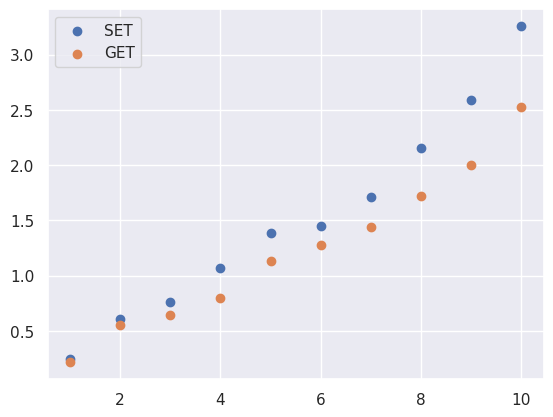

In [6]:
# 尝试画出set和get的latency变化图
x = list(map(lambda x : x[0] / base_client, local_scales))
# get command latency data varified by scale
def get_cmd_var(dfs:list, command:str, latency_list:list) -> pd.DataFrame:
    y = []
    for t, df in local_dfs[:length]:
        # x.append(int(t[0]/base_client))
        y.append(df.loc[command][latency_list])
    return pd.DataFrame(y)


y_set = []
y_get = []
for t, df in local_dfs[:length]:
    # x.append(int(t[0]/base_client))
    y_set.append(df.loc["SET"]["avg_latency_ms"])
    y_get.append(df.loc["GET"]["avg_latency_ms"])
plt.figure()
plt.scatter(x,y_set)
plt.scatter(x,y_get)
plt.legend(["SET","GET"])
plt.show()

In [7]:
def get_cmd_var(dfs:list, base_client, command, latency_list:list) -> pd.DataFrame:
    y = []
    x = []
    for t, df in dfs:
        x.append(int(t[0]/base_client))
        y.append(df.loc[command][latency_list])
    x = pd.Index(x, name="scale")
    return pd.DataFrame(y,index=x)

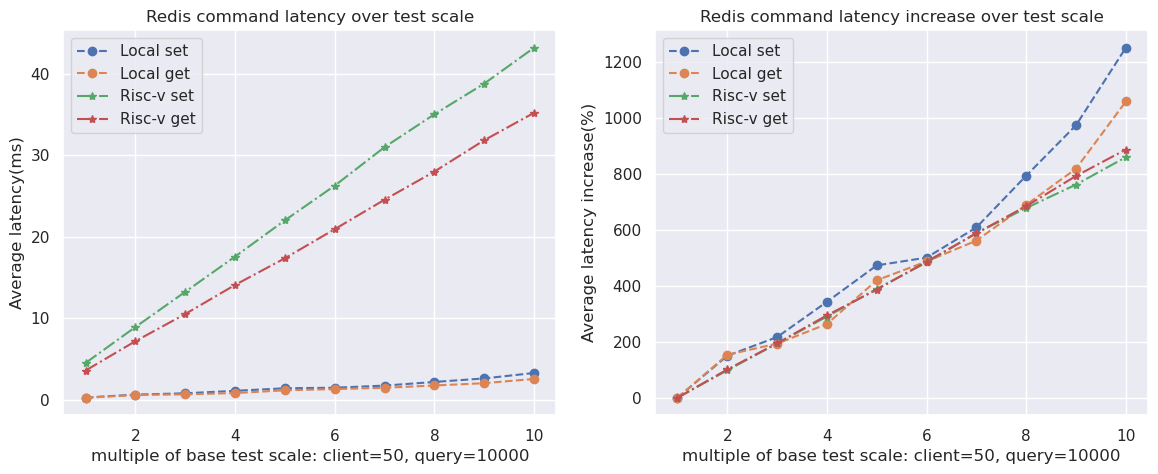

In [8]:
# get figure for latency over test scale
plt.figure(figsize=(14, 5))
ax1 = plt.subplot(1,2,1)

plt.title("Redis command latency over test scale")
plt.xlabel(f"multiple of base test scale: client={base_client}, query={base_query}")
plt.ylabel(f"Average latency(ms)")

local_set_avg = get_cmd_var(local_dfs[:length], base_client, "SET", ["avg_latency_ms"])
plt.plot(local_set_avg, linestyle='dashed', marker='o', label="Local set")
local_get_avg = get_cmd_var(local_dfs[:length], base_client, "GET", ["avg_latency_ms"])
plt.plot(local_get_avg, linestyle='dashed', marker='o', label="Local get")

rv_set_avg = get_cmd_var(rv_dfs[:length], base_client, "SET", ["avg_latency_ms"])
plt.plot(rv_set_avg, linestyle='-.', marker='*', label="Risc-v set")
rv_get_avg = get_cmd_var(rv_dfs[:length], base_client, "GET", ["avg_latency_ms"])
plt.plot(rv_get_avg, linestyle='-.', marker='*', label="Risc-v get")

plt.legend()

# display increasement
ax2 = plt.subplot(1,2,2)

def compute_inc_percentage(data: pd.DataFrame) -> pd.DataFrame:
    return (data / data.iloc[0] - 1) * 100

local_set_inc = compute_inc_percentage(local_set_avg)
local_get_inc = compute_inc_percentage(local_get_avg)
rv_set_inc = compute_inc_percentage(rv_set_avg)
rv_get_inc = compute_inc_percentage(rv_get_avg)

plt.title("Redis command latency increase over test scale")
plt.xlabel(f"multiple of base test scale: client={base_client}, query={base_query}")
plt.ylabel(f"Average latency increase(%)")

plt.plot(local_set_inc, linestyle='dashed', marker='o', label="Local set")
plt.plot(local_get_inc, linestyle='dashed', marker='o', label="Local get")
plt.plot(rv_set_inc, linestyle='-.', marker='*', label="Risc-v set")
plt.plot(rv_get_inc, linestyle='-.', marker='*', label="Risc-v get")
plt.legend()
plt.show()

<Figure size 640x480 with 0 Axes>

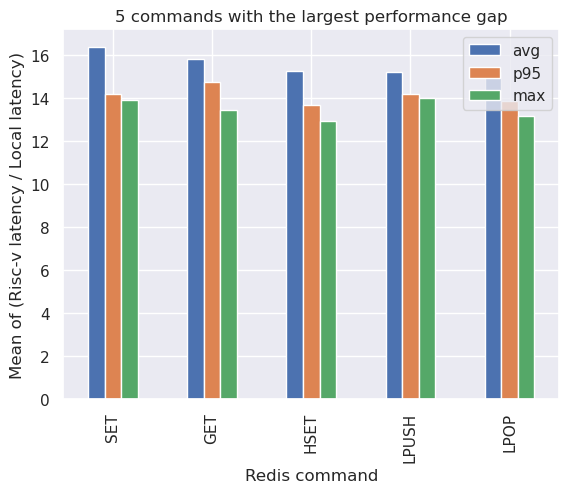

In [9]:
# plot bar for latency difference(avg_latency, p95_latency, max_latency)

# compute avg latency diference for every redis command
get_cmd_var(local_dfs[:length], base_client, "SET", ["avg_latency_ms"])

def extract(x):
    return x[1][["avg_latency_ms", "p95_latency_ms", "max_latency_ms"]]

local_dfs_extract = map(extract,local_dfs[:length])
rv_dfs_extract = map(extract,rv_dfs[:length])

diff = list(map(lambda x, y : x / y, rv_dfs_extract, local_dfs_extract))

# compute mean
total = reduce(lambda x, y: x + y, diff)
mean = total / len(diff)
idx = mean['avg_latency_ms'].nlargest(5).index
to_plt = mean.loc[idx]
idx_cut = idx.str.split().str[0]
to_plt = to_plt.set_index(idx_cut)

plt.figure()
to_plt.plot(kind='bar')
plt.title("5 commands with the largest performance gap")
plt.xlabel('Redis command')
plt.ylabel('Mean of (Risc-v latency / Local latency)')
plt.legend(['avg', 'p95', 'max'])
plt.show()


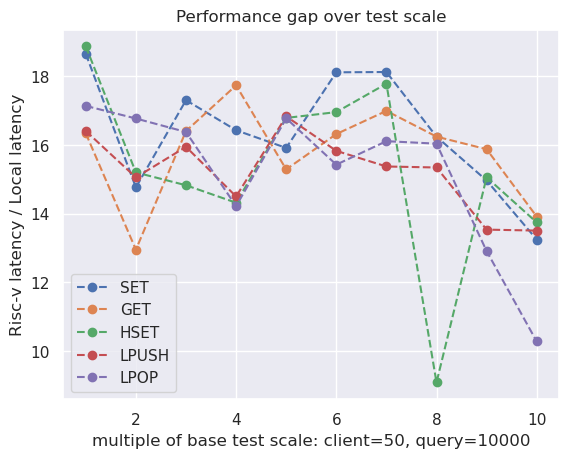

In [10]:

# compute change over performance gap
df = pd.DataFrame(map(lambda x: x.loc[idx]['avg_latency_ms'],diff))
index=local_get_avg.index.set_names("")
df = pd.DataFrame(df.values, columns=idx_cut.set_names(""), index=index)
df.plot(linestyle='dashed', marker='o')
plt.title("Performance gap over test scale")
plt.xlabel(f"multiple of base test scale: client={base_client}, query={base_query}")
plt.ylabel("Risc-v latency / Local latency")
plt.show()

In [11]:
# CPU和网络带宽的变化
monitor_dir = 'results/monitor/'
def iter_file_dict(path:str):
    iter_dict = {}
    for _, _, files in os.walk(path):
                for file in files:
                    iter = int(file.split('_')[0].removeprefix('iter'))
                    iter_dict[iter] = file
    return iter_dict
cpu_iter_dict = iter_file_dict(monitor_dir + 'cpu')
cpu_iter_dict[max(cpu_iter_dict)]


'iter8_cpu.log'

In [ ]:
# 导入路径
import sys
sys.path.append('..')

In [22]:
from monitor.plot import plot_state_log

def plot_iter(plt, monitor_dir:str, i:int):
    plt.figure(figsize=(10, 12))
    ax1 = plt.subplot(2,1,1)
    plot_state_log(plt, monitor_dir + f'cpu/iter{i}_cpu.log', 'cpu' ,from_zero=True)
    ax1 = plt.subplot(2,1,2)
    plot_state_log(plt, monitor_dir + f'net/iter{i}_net.log', 'net',from_zero=True)

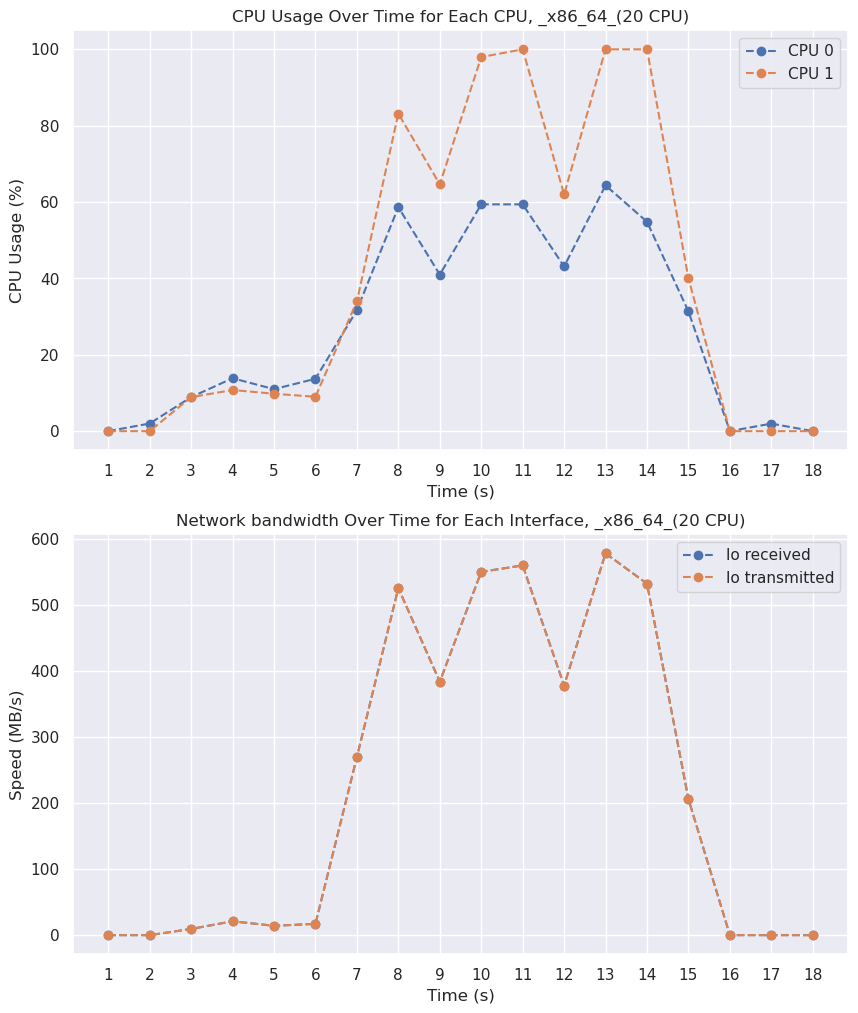

In [23]:
plot_iter(plt, monitor_dir,7)
plt.show()

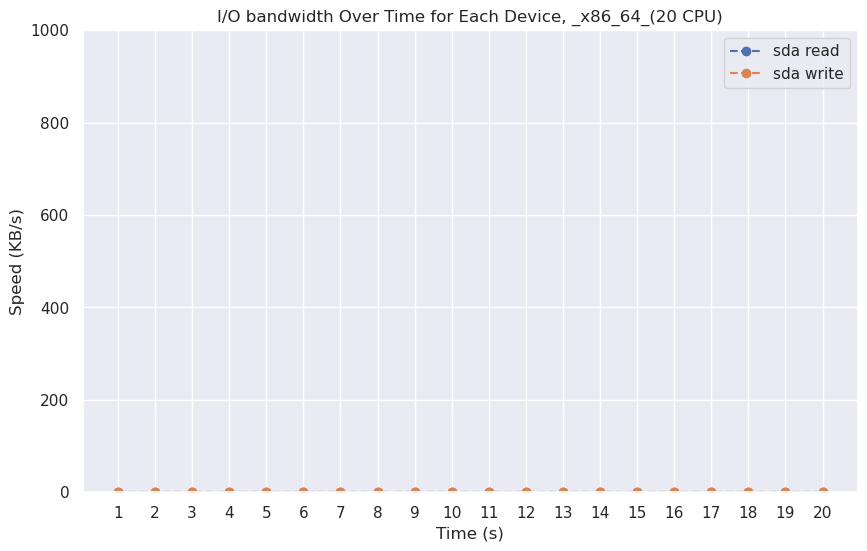

In [14]:
# Plot the CPU usage for each CPU
plt.figure(figsize=(10, 6))
plot_state_log(plt, monitor_dir + 'io/iter8_io.log', 'io',from_zero=True)
plt.ylim((0,1000))
plt.show()